<a href="https://colab.research.google.com/github/Vikash-Chaubey7061/DATA-SCIENCE-PROJECT-USING-PYTHON/blob/main/Shopper_Spectrum_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "/content/online_retail.csv"
df = pd.read_csv(url, encoding='ISO-8859-1') # Use read_csv for .csv file and specify encoding

# Initial exploration
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       ------------

Data Preprocessing

In [10]:
# Data Preprocessing
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notna()]

# Exclude cancelled invoices (those starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print(f"Cleaned dataset shape: {df.shape}")

Cleaned dataset shape: (397884, 9)


# Exploratory Data Analysis

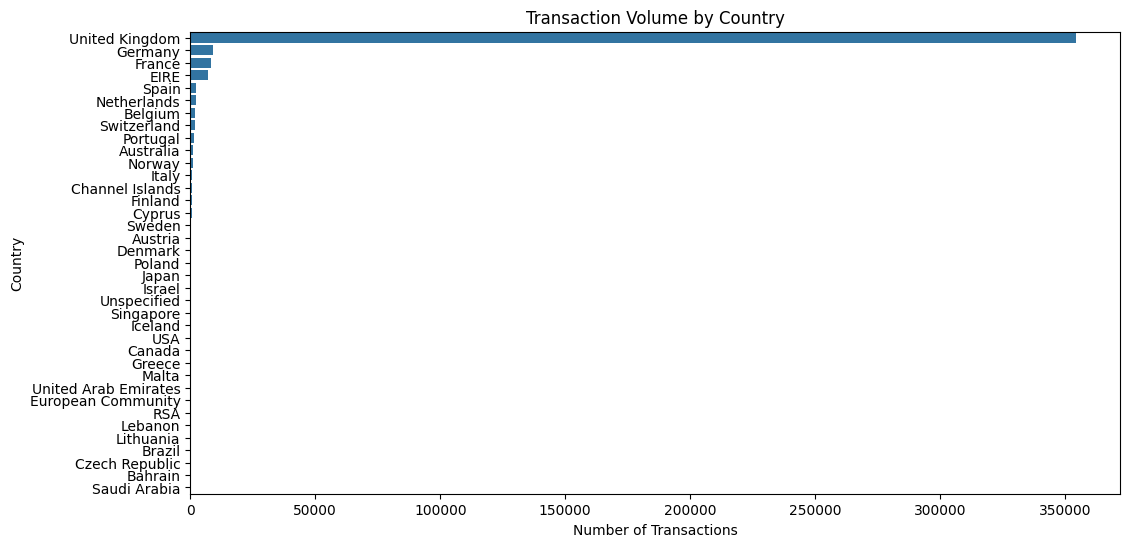

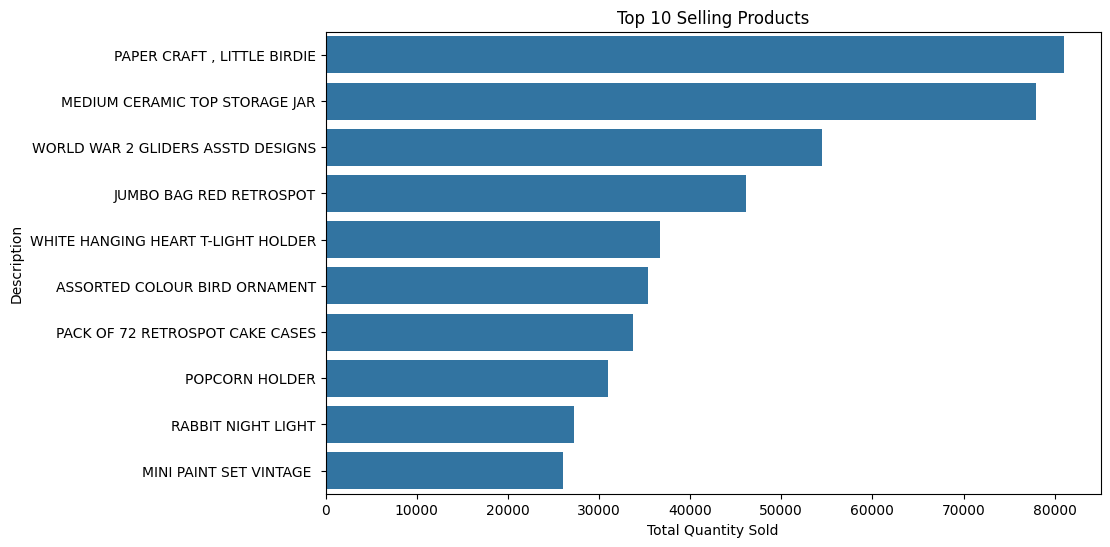

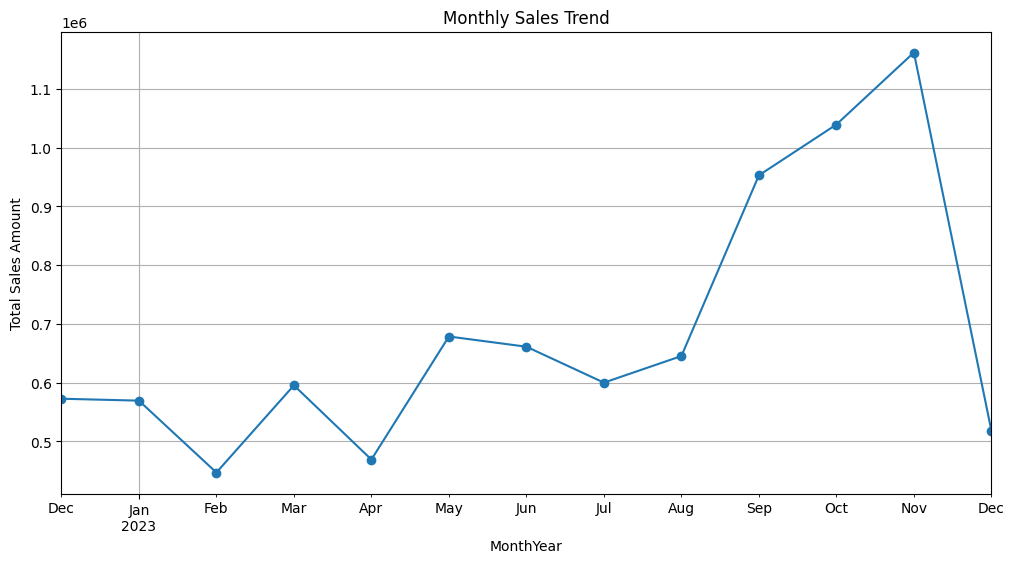

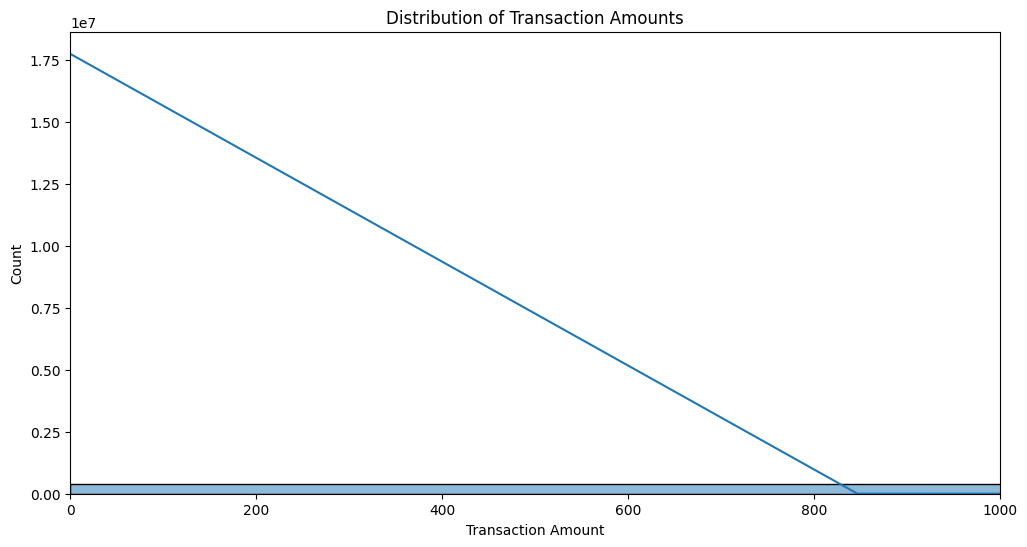

In [11]:
# Exploratory Data Analysis
# 1. Transaction volume by country
plt.figure(figsize=(12,6))
country_counts = df['Country'].value_counts()
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title('Transaction Volume by Country')
plt.xlabel('Number of Transactions')
plt.show()

# 2. Top-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Selling Products')
plt.xlabel('Total Quantity Sold')
plt.show()

# 3. Purchase trends over time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('MonthYear')['TotalAmount'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales Amount')
plt.grid(True)
plt.show()

# 4. Monetary distribution
plt.figure(figsize=(12,6))
sns.histplot(df['TotalAmount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.xlim(0, 1000)  # Limit to better see the distribution
plt.show()

Exploratory Data Analysis (EDA)-Exploratory Data Analysis (EDA) is the first and most crucial step in any data science or machine learning project. It involves summarizing and visualizing the important characteristics of a dataset to understand its structure, detect patterns, spot anomalies, and generate hypotheses.

RFM Analysis and Customer Segmentation-
Now we'll implement the RFM (Recency, Frequency, Monetary) analysis:

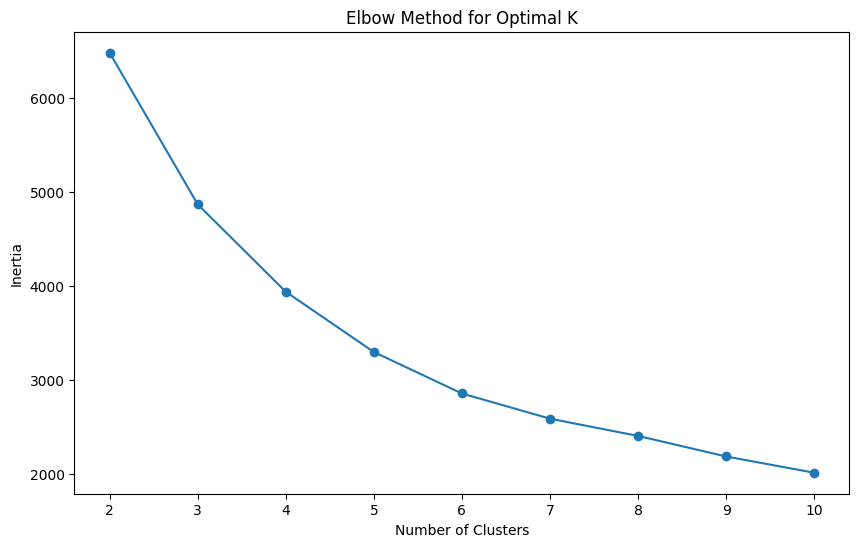

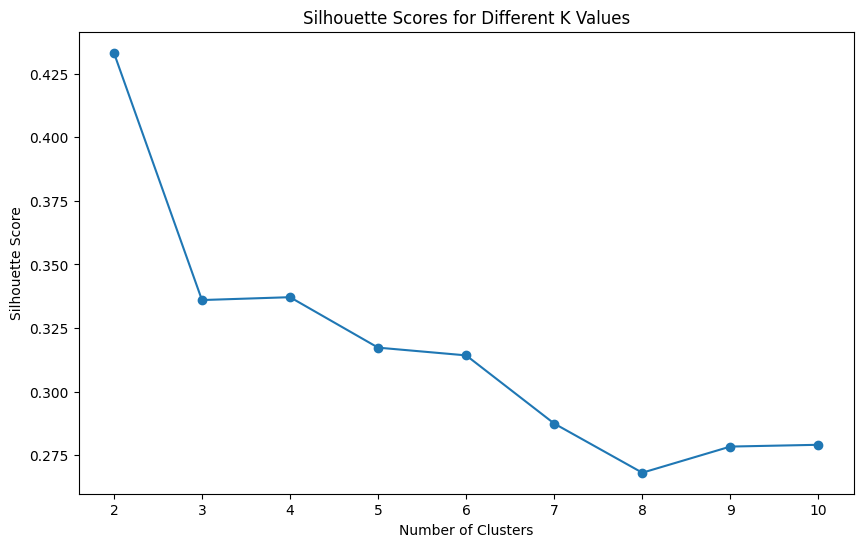

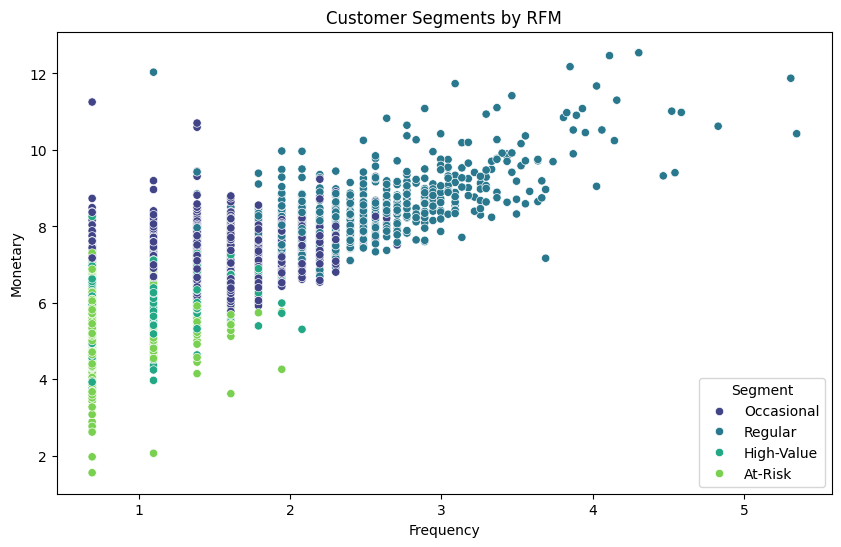

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate RFM metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'     # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

# Apply log transformation to handle skewness
rfm['Recency'] = np.log1p(rfm['Recency'])
rfm['Frequency'] = np.log1p(rfm['Frequency'])
rfm['Monetary'] = np.log1p(rfm['Monetary'])

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine optimal number of clusters using elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2,11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Also check silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, cluster_labels))

plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Based on the plots, choose the optimal K (let's assume K=4 as per the document)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Map clusters to segment names as per the document
cluster_map = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_map)

# Visualize the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='viridis')
plt.title('Customer Segments by RFM')
plt.show()

Product Recommendation System (Collaborative Filtering).
Now let's implement the item-based collaborative filtering system
A Product Recommendation System using Collaborative Filtering suggests products to users based on preferences of similar users or similar items. It's widely used in platforms like Amazon, Netflix, or Zomato.

Collaborative Filtering?
Collaborative Filtering relies on past user behavior, not product features.

There are two main types:

User-Based Filtering
→ Recommend products liked by similar users.

Item-Based Filtering
→ Recommend products similar to what the user has liked.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Create customer-item matrix
customer_item_matrix = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum'
)

# Fill NA values with 0
customer_item_matrix.fillna(0, inplace=True)

# Create item-item similarity matrix
item_similarity = cosine_similarity(customer_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                index=customer_item_matrix.columns,
                                columns=customer_item_matrix.columns)

# Function to get similar products
def get_similar_products(product_id, n=5):
    similar_products = item_similarity_df[product_id].sort_values(ascending=False)
    similar_products = similar_products.drop(product_id)  # Remove the product itself
    return similar_products.head(n)

# Example usage
sample_product = df['StockCode'].value_counts().index[0]  # Get a popular product
similar_items = get_similar_products(sample_product)
print(f"Products similar to {df[df['StockCode']==sample_product]['Description'].iloc[0]}:")
for item in similar_items.index:
    print(df[df['StockCode']==item]['Description'].iloc[0])

Products similar to WHITE HANGING HEART T-LIGHT HOLDER:
GIN + TONIC DIET METAL SIGN
RED HANGING HEART T-LIGHT HOLDER
WASHROOM METAL SIGN
LAUNDRY 15C METAL SIGN
GREEN VINTAGE SPOT BEAKER


#Streamlit App Implementation

Streamlit is a Python library that lets you build web apps for data science and machine learning in minutes using only Python scripts.


In [17]:
%pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.0 MB/s eta 0:00:00


In [24]:
import streamlit as st
import pickle

# Load the models and data
@st.cache_data
def load_data():
    # Load your preprocessed data and models here
    rfm = pd.read_pickle('rfm_data.pkl')
    kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))
    item_similarity_df = pd.read_pickle('item_similarity.pkl')
    product_descriptions = df[['StockCode', 'Description']].drop_duplicates()
    return rfm, kmeans, item_similarity_df, product_descriptions

rfm, kmeans, item_similarity_df, product_descriptions = load_data()

# Streamlit app
st.title('Shopper Spectrum: Customer Segmentation and Product Recommendations')

# Product Recommendation Module
st.header('Product Recommender')
product_query = st.text_input('Enter Product Name', 'GREEN VINTAGE SPOT BEAKER')

if st.button('Get Recommendations'):
    try:
        # Find the StockCode for the entered product name
        stock_code = product_descriptions[
            product_descriptions['Description'].str.contains(product_query, case=False)
        ]['StockCode'].values[0]

        # Get similar products
        similar_items = get_similar_products(stock_code)

        st.subheader('Recommended Products')
        for item in similar_items.index:
            desc = product_descriptions[product_descriptions['StockCode']==item]['Description'].values[0]
            st.write(f"- {desc}")
    except:
        st.error("Product not found. Please try another product name.")

# Customer Segmentation Module
st.header('Customer Segmentation')
col1, col2, col3 = st.columns(3)

with col1:
    recency = st.number_input('Recency (days since last purchase)', min_value=0, value=30)
with col2:
    frequency = st.number_input('Frequency (number of purchases)', min_value=1, value=5)
with col3:
    monetary = st.number_input('Monetary (total spend)', min_value=0.0, value=500.0)

if st.button('Predict Segment'):
    # Preprocess the input
    input_data = pd.DataFrame([[np.log1p(recency), np.log1p(frequency), np.log1p(monetary)]],
                            columns=['Recency', 'Frequency', 'Monetary'])
    input_scaled = scaler.transform(input_data)

    # Predict cluster
    cluster = kmeans.predict(input_scaled)[0]
    segment = cluster_map[cluster]

    st.success(f"This customer belongs to: {segment} Segment")

2025-07-29 16:07:55.503 No runtime found, using MemoryCacheStorageManager
2025-07-29 16:07:55.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.619 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-29 16:07:55.625 Thread 'MainThread':

In [20]:
import pickle

# Save RFM data
rfm.to_pickle('rfm_data.pkl')

# Save KMeans model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Save item similarity matrix
item_similarity_df.to_pickle('item_similarity.pkl')

print("RFM data, KMeans model, and item similarity matrix saved successfully.")

RFM data, KMeans model, and item similarity matrix saved successfully.
